In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 7]
from torchvision import datasets
import torch
from catboost import CatBoostClassifier

In [ ]:
#!pip install catboost

# **Однослойная нейронная сеть с SVD оптимизацией.**

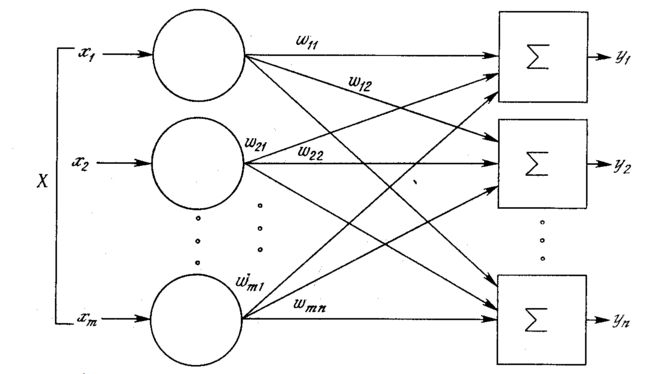

**Загружаем набор данных для классификации рукописных цифр.**

In [ ]:
data_folder = '~/data/MNIST'

mnist_train = datasets.MNIST(data_folder, download=True, train=True)
mnist_train.data = (torch.reshape(mnist_train.data, (mnist_train.data.shape[0], -1))).numpy().astype(np.float32) / 255.
mnist_train.targets = mnist_train.targets.numpy().astype(np.int8)

mnist_test = datasets.MNIST(data_folder, download=True, train=False)
mnist_test.data = (torch.reshape(mnist_test.data, (mnist_test.data.shape[0], -1))).numpy().astype(np.float32) / 255.
mnist_test.targets = mnist_test.targets.numpy().astype(np.int8)

Тренировочный набор данных имеет размерность 60000 x 28 x 28, преобразуем его в 60000 x 784 и нормализуем данные, разделив на 255.
Ааналогично преобразуем тестовый набор данных, который будет иметь размерность 10000 x 784. 

In [ ]:
mnist_train.data[0, 150:200]

array([0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
       0.07058824, 0.49411765, 0.53333336, 0.6862745 , 0.10196079,
       0.6509804 , 1.        , 0.96862745, 0.49803922, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11764706, 0.14117648, 0.36862746, 0.6039216 ,
       0.6666667 , 0.99215686, 0.99215686, 0.99215686, 0.99215686,
       0.99215686, 0.88235295, 0.6745098 , 0.99215686, 0.9490196 ,
       0.7647059 , 0.2509804 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [ ]:
mnist_train.data.shape, mnist_train.targets.shape

((60000, 784), (60000,))

**Инициализация матрицы весов и вектора смещений.**

In [ ]:
num_inputs = 784    # Количество входов сети 
num_outputs = 10    # Количество выходов сети

In [ ]:
# Матрица весов
weights_init = np.random.normal(0., 0.5, size=(num_inputs, num_outputs))
weights_init[:5, :]

array([[ 0.88077354,  0.44706388,  0.48207882, -0.1568334 , -0.05279349,
         0.06530747, -0.71194679,  0.04816108,  1.09376977, -0.37097471],
       [-0.39227751,  0.00527058, -0.36684894,  0.1943152 , -0.27638749,
         0.12049491,  0.20157999, -0.00388257, -0.30538854, -0.29882235],
       [ 0.20128923, -0.05511775,  0.44054141,  0.30574115,  0.77361559,
        -0.5997161 ,  0.11757006,  0.39414084, -1.0995966 , -0.88415813],
       [ 0.14428748, -0.83013504, -0.07235888,  1.10880829, -0.97474846,
         0.37601227,  0.359074  , -0.55095894, -0.94710238,  0.16341986],
       [ 0.4426798 , -0.43621437, -0.0787722 , -0.2104083 ,  0.97448794,
         0.37861445, -0.01854113,  0.21339877, -0.33774407,  0.48593932]])

In [ ]:
# Вектор смещений
bias_init = np.random.normal(0., 0.5, size=(num_outputs))
bias_init

array([ 0.03136984, -0.19657227, -0.03565772,  0.80432406, -0.45069423,
        0.435116  , -0.41010823,  0.69595921,  0.1254352 ,  0.1402612 ])

**Функция softmax.**

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

**Метод, реализующий обучение модели.**

In [ ]:
# Обучение модели
def fit(inputs, y_true, weights, bias, learn_rate, apply_svd, svd_components, loss):
    Z = inputs @ weights.T + bias
    
    # Кросс-энтропия
    sum = 0
    for zi, classId in zip(Z, y_true):
        probs = softmax(zi)
        sum += np.log(probs[classId])

    loss.append(- sum / Z.shape[0])

    # Градиентный спуск
    d_L_d_Z = np.zeros(Z.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]): # Для каждого класса
            if j == y_true[i]:
                d_L_d_Z[i,j] = (-1.0 / Z.shape[0]) * (1 - softmax(Z[i])[j])
            else: d_L_d_Z[i,j] = (-1.0 / Z.shape[0]) * (0 - softmax(Z[i])[j])

    if apply_svd:   # Применить SVD разложение
        U, S, V = np.linalg.svd(d_L_d_Z.T, full_matrices=False)
        M = V[0:svd_components, :] @ inputs
        weights -= learn_rate * (U[:, 0:svd_components] @ np.diag(S[0:svd_components]) @ M)
    else:
        weights -= learn_rate * (d_L_d_Z.T @ inputs)
     
    d_L_d_B = np.ones((1, Z.shape[0])) @ d_L_d_Z

    bias -= learn_rate * d_L_d_B[0]

**Метод, реализующий предсказание.**

In [ ]:
def predict(X, weights, bias):
    y_pred = []
    Z = X @ weights + bias
    for zi in Z:
        y_pred.append(np.argmax(softmax(zi)))

    return y_pred

**Гиперпараметры модели.**

In [ ]:
epochs = 1000        # сколько раз пройти по всему набору данных
learning_rate = 0.1  # Скорость обучения
packet_size = 512    # Размер пакета данных
count_packtes = 7    # Сколько пакетов используем для обучения модели

**Обучение модели без SVD оптимизации.**

In [ ]:
%%time

loss = []
accuracy = []

weights = np.copy(weights_init)
bias = np.copy(bias_init)

packets_ranges = [(idx - packet_size, idx) for idx in range(packet_size, mnist_train.data.shape[0], packet_size)]
#packets_ranges.append((packets_ranges[-1][1], mnist_train.data.shape[0] - 1))
np.random.shuffle(packets_ranges)   # Выбираем пакет случайным образом

# Мини-пакетное обучение
for epoch in range(epochs):
    loss_ = []
    for idx, (idx_start, idx_end) in enumerate(packets_ranges):
        if idx >= count_packtes: break

        fit(inputs = mnist_train.data[idx_start:idx_end, :], y_true = mnist_train.targets[idx_start:idx_end], weights = weights.T, bias = bias,
            learn_rate = learning_rate, apply_svd = False, svd_components = 7, loss = loss_)
    
    loss.append(np.array(loss_).mean())

    if epoch % 100 == 0:
      y_pred = predict(mnist_test.data, weights, bias)
      acc = accuracy_score(mnist_test.targets, y_pred)
      accuracy.append(acc)
      print("Epoch {}: loss - {}, accuracy - {}".format(epoch, loss[-1], acc))

model_weights = weights.copy()
model_bias = bias.copy()

Epoch 0: loss - 6.100212539132145, accuracy - 0.0998
Epoch 100: loss - 0.46397661675246205, accuracy - 0.8345
Epoch 200: loss - 0.33603361046531804, accuracy - 0.8611
Epoch 300: loss - 0.27715415193734233, accuracy - 0.8718
Epoch 400: loss - 0.23984207317820225, accuracy - 0.8755
Epoch 500: loss - 0.21304499857021492, accuracy - 0.8786
Epoch 600: loss - 0.19257506169352787, accuracy - 0.8807
Epoch 700: loss - 0.17630360662592032, accuracy - 0.8825
Epoch 800: loss - 0.16296603418909048, accuracy - 0.8821
Epoch 900: loss - 0.15175908129118199, accuracy - 0.8831
CPU times: user 17min 53s, sys: 11min 14s, total: 29min 8s
Wall time: 17min 20s


**Обучение модели с SVD оптимизацией.**

SVD оптимизация происходит следующим образом: применяется низкоранговое приближение, усечение до 5 компонентов (вместо 10), к матрице градиентов, используемой для корректировки значений матрицы весов W.

In [ ]:
%%time

loss_svd = []
accuracy_svd = []

weights = np.copy(weights_init)
bias = np.copy(bias_init)

packets_ranges = [(idx - packet_size, idx) for idx in range(packet_size, mnist_train.data.shape[0], packet_size)]
#packets_ranges.append((packets_ranges[-1][1], mnist_train.data.shape[0] - 1))
np.random.shuffle(packets_ranges)   # Выбираем пакет случайным образом

# Мини-пакетное обучение
for epoch in range(epochs):
    loss_ = []
    for idx, (idx_start, idx_end) in enumerate(packets_ranges):
        if idx >= count_packtes: break

        fit(inputs = mnist_train.data[idx_start:idx_end, :], y_true = mnist_train.targets[idx_start:idx_end], weights = weights.T, bias = bias,
            learn_rate = learning_rate, apply_svd = True, svd_components = 5, loss = loss_)
    
    loss_svd.append(np.array(loss_).mean())

    if epoch % 100 == 0:
      y_pred = predict(mnist_test.data, weights, bias)
      acc = accuracy_score(mnist_test.targets, y_pred)
      accuracy_svd.append(acc)
      print("Epoch {}: loss - {}, accuracy - {}".format(epoch, loss_svd[-1], acc))

model_weights_svd = weights.copy()
model_bias_svd = bias.copy()

Epoch 0: loss - 6.251241119222454, accuracy - 0.0889
Epoch 100: loss - 0.7518690153432249, accuracy - 0.7648
Epoch 200: loss - 0.5347954324659563, accuracy - 0.8142
Epoch 300: loss - 0.4470708916942665, accuracy - 0.832
Epoch 400: loss - 0.39414509513365753, accuracy - 0.8436
Epoch 500: loss - 0.3567350578785078, accuracy - 0.851
Epoch 600: loss - 0.32884420672372755, accuracy - 0.854
Epoch 700: loss - 0.30851667719946774, accuracy - 0.8558
Epoch 800: loss - 0.2924775939579431, accuracy - 0.8571
Epoch 900: loss - 0.2795696631975062, accuracy - 0.8577
CPU times: user 17min 57s, sys: 11min 5s, total: 29min 3s
Wall time: 17min 46s


**Обучение модели с SVD оптимизацией.**

SVD оптимизация происходит следующим образом: применяется низкоранговое приближение, усечение до 3 компонентов (вместо 10), к матрице градиентов, используемой для корректировки значений матрицы весов W.

In [ ]:
%%time

loss_svd_ = []
accuracy_svd_ = []

weights = np.copy(weights_init)
bias = np.copy(bias_init)

packets_ranges = [(idx - packet_size, idx) for idx in range(packet_size, mnist_train.data.shape[0], packet_size)]
#packets_ranges.append((packets_ranges[-1][1], mnist_train.data.shape[0] - 1))
np.random.shuffle(packets_ranges)   # Выбираем пакет случайным образом

# Мини-пакетное обучение
for epoch in range(epochs):
    loss_ = []
    for idx, (idx_start, idx_end) in enumerate(packets_ranges):
        if idx >= count_packtes: break

        fit(inputs = mnist_train.data[idx_start:idx_end, :], y_true = mnist_train.targets[idx_start:idx_end], weights = weights.T, bias = bias,
            learn_rate = learning_rate, apply_svd = True, svd_components = 3, loss = loss_)
    
    loss_svd_.append(np.array(loss_).mean())

    if epoch % 100 == 0:
      y_pred = predict(mnist_test.data, weights, bias)
      acc = accuracy_score(mnist_test.targets, y_pred)
      accuracy_svd_.append(acc)
      print("Epoch {}: loss - {}, accuracy - {}".format(epoch, loss_svd_[-1], acc))

model_weights_svd_ = weights.copy()
model_bias_svd_ = bias.copy()

Epoch 0: loss - 6.5701207716386465, accuracy - 0.0865
Epoch 100: loss - 1.0608544766278263, accuracy - 0.6739
Epoch 200: loss - 0.7834032523499245, accuracy - 0.7409
Epoch 300: loss - 0.666513656378375, accuracy - 0.7708
Epoch 400: loss - 0.5952877370077562, accuracy - 0.786
Epoch 500: loss - 0.5482008607448957, accuracy - 0.7987
Epoch 600: loss - 0.516281914063199, accuracy - 0.804
Epoch 700: loss - 0.49150540433568135, accuracy - 0.8085
Epoch 800: loss - 0.4684345739668049, accuracy - 0.8138
Epoch 900: loss - 0.4474520787742848, accuracy - 0.816
CPU times: user 17min 48s, sys: 11min 11s, total: 28min 59s
Wall time: 17min 25s


**График изменения потерь (кросс-энтропия) в процессе обучения с SVD оптимизацией и без нее.**

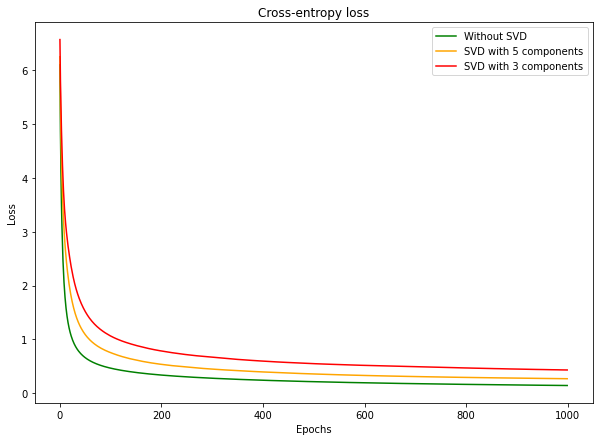

In [ ]:
plt.plot(loss, color='green', label='Without SVD')
plt.plot(loss_svd, color='orange', label='SVD with 5 components')
plt.plot(loss_svd_, color='red', label='SVD with 3 components')
plt.title("Cross-entropy loss")
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.show()

На графике видно, что чем больше SVD усечение, тем немного медленнее обучается модель.

**График изменения точности модели (доля правильных ответов) в процессе обучения с SVD оптимизацией и без нее.**

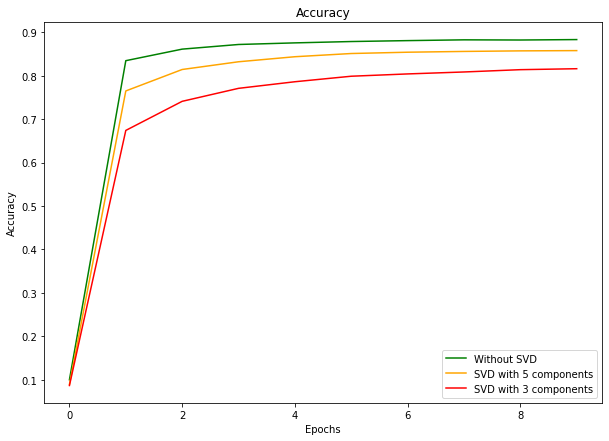

In [ ]:
plt.plot(accuracy, color='green', label='Without SVD')
plt.plot(accuracy_svd, color='orange', label='SVD with 5 components')
plt.plot(accuracy_svd_, color='red', label='SVD with 3 components')
plt.title("Accuracy")
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.legend()
plt.show()

На графике видно, что чем больше SVD усечение, тем точность модели немного ухудшается.

**Сравнение построенной модели на основе нейронной сети с известными моделями.**

**Гауссова наивная байесовская модель.**

In [ ]:
model = GaussianNB()

model.fit(mnist_train.data, mnist_train.targets)

y_pred = model.predict(mnist_test.data)

accuracy_score(mnist_test.targets, y_pred)

0.5558

**CatBoost от Яндекса.**

In [ ]:
model = CatBoostClassifier(loss_function="MultiClass", iterations=500, depth=5,
                           eval_metric="Accuracy", custom_metric="F1", 
                           random_seed=42, logging_level="Silent", use_best_model=False)

model.fit(mnist_train.data[:7000, :], mnist_train.targets[:7000],
          eval_set=(mnist_test.data, mnist_test.targets),
          plot=True)

y_pred = model.predict(mnist_test.data)

accuracy_score(mnist_test.targets, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9407

**Выводы:**
1. Обученная однослойная нейронная сеть показывает хорошее качество при класификации цифр на тестовых данных - 88.3 %.
2. При использовании SVD оптимизации качество модели незначительно ухудшается (усечение до 5 компонент - 85.7 %  усечение до 3 компонент - 81.6 %).  
3. Качество построенной модели лучше наивного байесовского классификатора - 55.5 %, но хуже CatBoost - 94 %.



